# Traffic Sign Recognition using CNN
This projects aims to recognise traffic signs using a simple Convolutional Neural Network (CNN). <br>
I used the **German Traffic Sign Recognition Benchmark (GTSRB)** dataset, which contains over 50,000 images of 43 different traffic sign labels. The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign).

## Importing necessary libraries

In [1]:
import os #for file system operations
import cv2 #for advanced image processing
import random #for selecting randomized data
import numpy as np #for numerical operations
import pandas as pd #for data manipulation
from matplotlib import pyplot as plt #for data visualization
from sklearn.model_selection import train_test_split #for data splitiing
#for building the model
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for augmentation
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout #for the layers
import warnings
warnings.filterwarnings('ignore')

## Loading the data
Set the current working directory to the 'Train' folder to access the training dataset, label wise. Load and resize the images to 30x30 pixels, and store them along with their labels.

In [2]:
os.chdir(os.path.join(os.getcwd(), "data"))
curr_path = os.path.join(os.getcwd(), "Train")

In [3]:
data = []
labels = []
classes = 43

#getting images and their respective labels
for i in os.listdir(curr_path):
    path = os.path.join(curr_path, str(i))
    for j in os.listdir(path):
        img_path = os.path.join(path, str(j))
        img = cv2.imread(img_path)

        #skip the file if empty
        if img is None: 
            print(f"Failed to load the image.")
            continue
        
        img = cv2.resize(img, (30, 30))
        data.append(img)
        labels.append(i)

#converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

Failed to load the image.
Failed to load the image.
Failed to load the image.


In [4]:
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


## Data Visualization
### Visualizing a sample of random images from the Training set

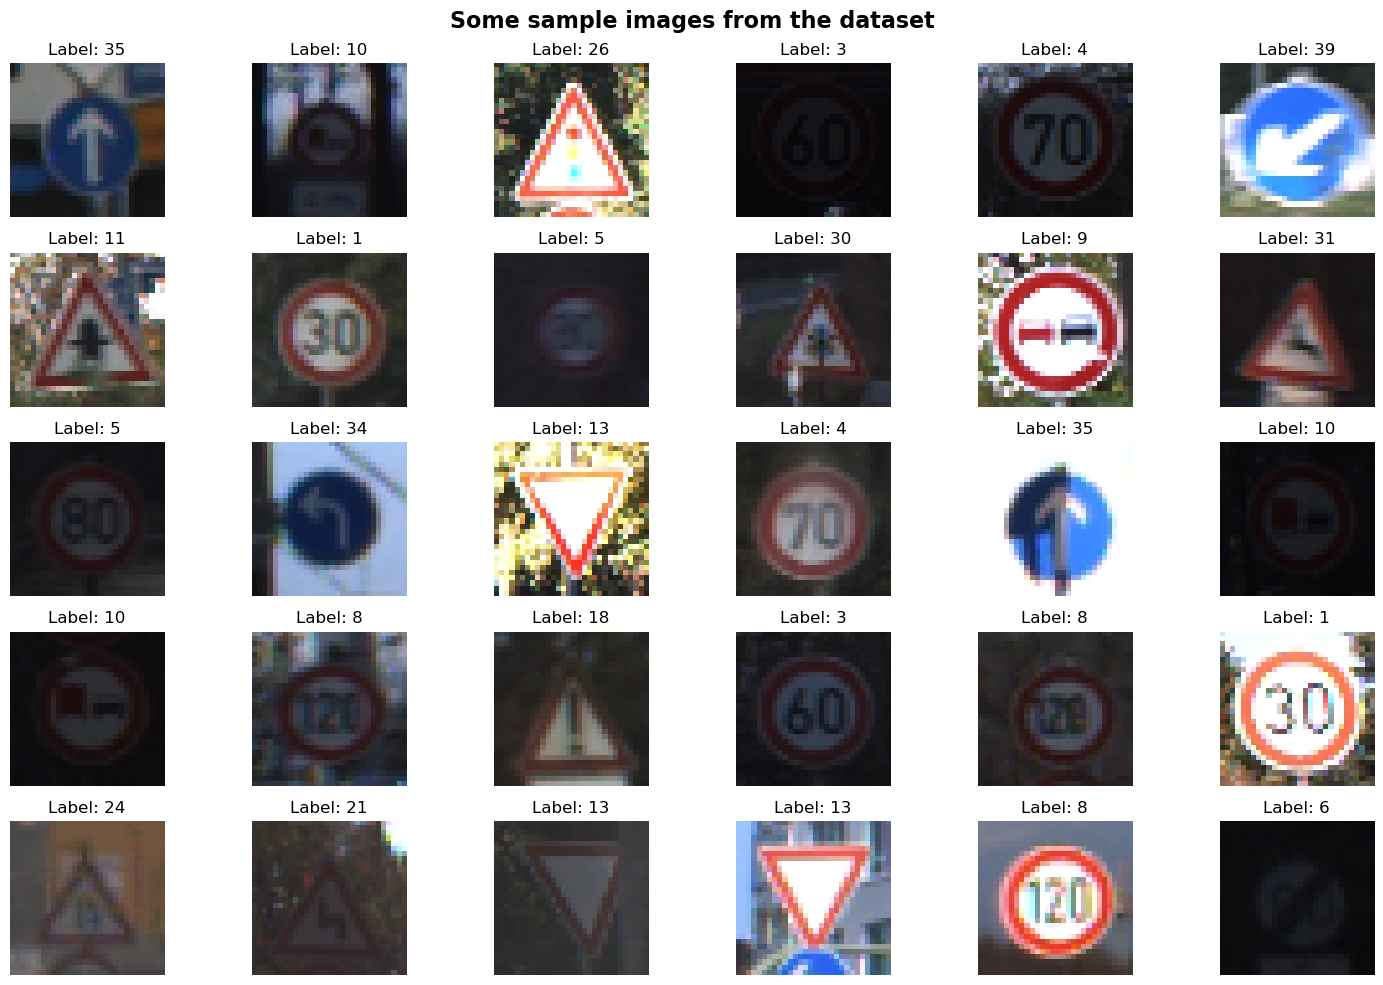

In [5]:
#displaying some of the images
samples = random.sample(range(len(data)), 30)

fig, axes = plt.subplots(5, 6, figsize = (15, 10))
fig.suptitle("Some sample images from the dataset", fontsize = 16, fontweight = 'bold')

for i, ind in enumerate(samples):
    r = i//6
    c = i%6
    img = data[ind]
    label = labels[ind]
    axes[r, c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[r, c].set_title(f"Label: {label}")
    axes[r, c].axis('off')
plt.tight_layout()
plt.show()

### Visualizing the Class Distribution
This will provide us a distribution of data with respect to each labels (classes). The histogram will help us to identify any class imbalance.

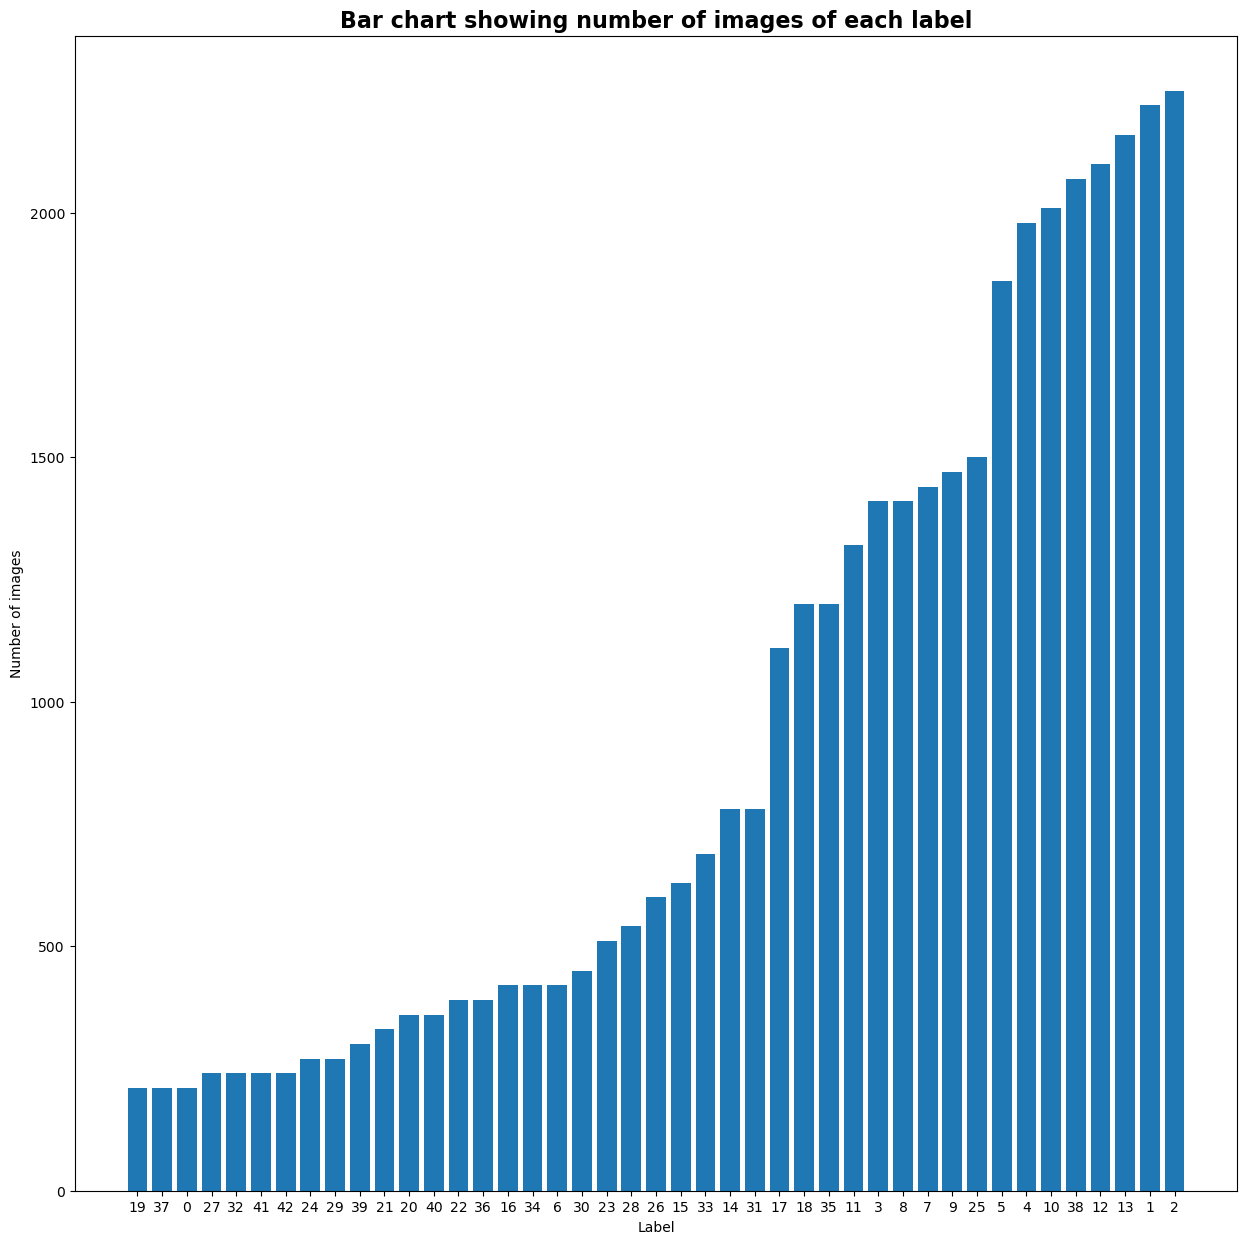

In [6]:
#using bar plots to display the frequency of each sign
data_count = {}
for i in os.listdir(curr_path):
    data_count[i] = len(os.listdir(os.path.join(curr_path, str(i))))

data_count = dict(sorted(data_count.items(), key = lambda x:x[1]))
plt.figure(figsize = (15, 15))
plt.bar(data_count.keys(), data_count.values())
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Bar chart showing number of images of each label", fontsize = 16, fontweight = 'bold')
plt.show()

## Normalization and splitting of Training data set
In the RGB format, the pixel values range from 0 to 255. Thus, the data is rescaled to have a range between 0 and 1. <br>
The dataset is then split into 80% training data and 20% validation data to evaluate the performance of the model on unseen data during training.

### One-hot encoding the labels
The model gives the probabilities for each of the 43 classes. For training the model properly, the labels are converted into one-hot encoded vectors.

In [7]:
#normalization
data = data/255

In [8]:
#splitting the dataset into training and testing dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

#converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(31367, 30, 30, 3) (31367, 43)
(7842, 30, 30, 3) (7842, 43)


## Data Augmentation
To help the model generalise better, apply random transformations (like rotation and shifting) to training images.

In [9]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.15, 
    width_shift_range=0.1, 
    height_shift_range=0.1)

## Building the CNN Model
### Model Architecture:
1. **Two Convolutional Layers (32 filters)**  
   * Filter size: 5x5  
   * Activation: ReLU  
   * Detects low-level features (edges, corners)


2. **MaxPooling Layer**  
   * Reduces image size (downsampling)  
   * Helps with generalization and reduces computation


3. **Dropout (25%)**  
   * Randomly turns off neurons during training to prevent overfitting


4. **Two More Convolutional Layers (64 filters)**  
   * Smaller filter size: 3x3  
   * Learns more complex patterns (shapes, signs)


5. **MaxPooling + Dropout (25%)**  
   * Further reduce dimensions and regularize


6. **Flatten Layer**  
   * Converts 2D feature maps into 1D vector


7. **Dense Layer (256 units)**  
   * Fully connected layer to learn combinations of features  
   * Activation: ReLU


8. **Dropout (50%)**  
   * Stronger regularization before the final output layer


9. **Output Layer (43 units)**  
   * Softmax activation to output class probabilities for all 43 traffic sign categories

In [10]:
#building the model
model = Sequential()

#first layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

#second layer 
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

#dense layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model
'adam' optimizer adapts learning rate during training.
'categorical_crossentropy' loss is suitable for multi-class classification.
'accuracy' metric is used to monitor model performance.

In [11]:
#compiling the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

## Training the model
Train the model using the augmented data for 15 epochs. The validation set helps monitor the performance during training.

In [12]:
#fitting the data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    validation_data=(X_val, y_val), 
    epochs=15)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.1890 - loss: 2.9670 - val_accuracy: 0.8063 - val_loss: 0.5842
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.6987 - loss: 0.9580 - val_accuracy: 0.9563 - val_loss: 0.1661
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.8282 - loss: 0.5449 - val_accuracy: 0.9732 - val_loss: 0.0947
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - accuracy: 0.8817 - loss: 0.3747 - val_accuracy: 0.9762 - val_loss: 0.0702
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.9060 - loss: 0.3065 - val_accuracy: 0.9893 - val_loss: 0.0382
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.9258 - loss: 0.2465 - val_accuracy: 0.9890 - val_loss: 0.0372
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.9305 - loss: 0.2237 - val_accuracy: 0.9932 - val_loss: 0.0249
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.9397 - loss: 0.2040 - 

## Plotting Accuracy and Loss
To understand whether the model is overfitting or underfitting, visualize how accuracy and loss changes over epochs for both training and validation sets.

Text(0, 0.5, 'Accuracy')

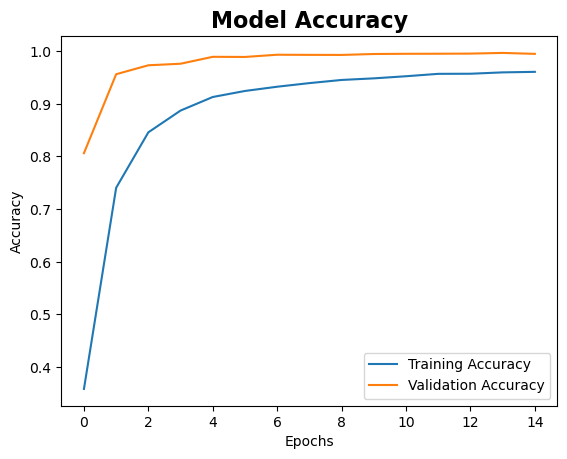

In [13]:
#plotting trainining history
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

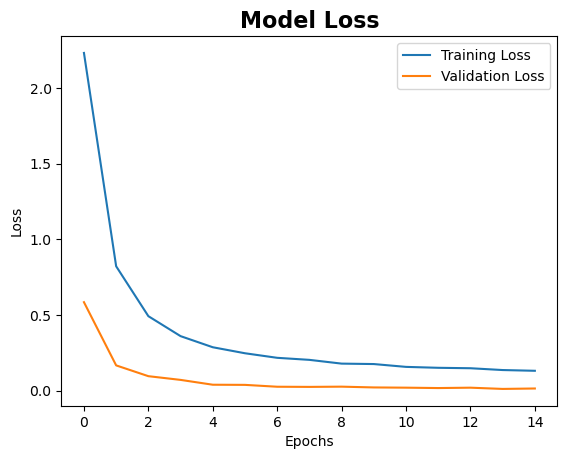

In [14]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Model Loss', fontsize = 16, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Testing on new images
Load the test data from the test set, preprocess it and use the model to predict their labels. 

In [15]:
curr_path = os.path.join(os.getcwd(), "Test.csv")

In [16]:
#testing over test set
test_data = pd.read_csv(curr_path)
y_test = test_data["ClassId"].values
path = test_data["Path"].values
data = []
for img_path in path:
    img = cv2.imread(img_path)
    if img is None: 
            print(f"Failed to load image: {img_path}")
            continue
        
    img = cv2.resize(img, (30, 30))
    data.append(img)
X_test = np.array(data)

#normalization
X_test = X_test/255

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns #for heat map to be used in confusion_matrix

In [18]:
#predicting test set labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
print(f"Accuracy Score of the model: {accuracy_score(y_test, y_pred)*100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Accuracy Score of the model: 97.02%


# Saving the Model

In [19]:
os.chdir("..")
model.save("traffic_sign_model.h5")

## Confusion Matrix
The confusion matrix gives a visual overview of where the model gets confused between different classes. <br>
It can be useful if one wants to improve the model in the future.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99       720
           2       0.96      0.99      0.98       750
           3       0.94      0.99      0.96       450
           4       0.98      0.97      0.98       660
           5       0.99      0.90      0.94       630
           6       1.00      0.75      0.85       150
           7       0.98      0.99      0.98       450
           8       0.99      0.96      0.98       450
           9       0.99      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.98      0.95      0.97       420
          12       1.00      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.96      0.99      0.97       210
          16       0.99      1.00      0.99       150
          17       1.00    

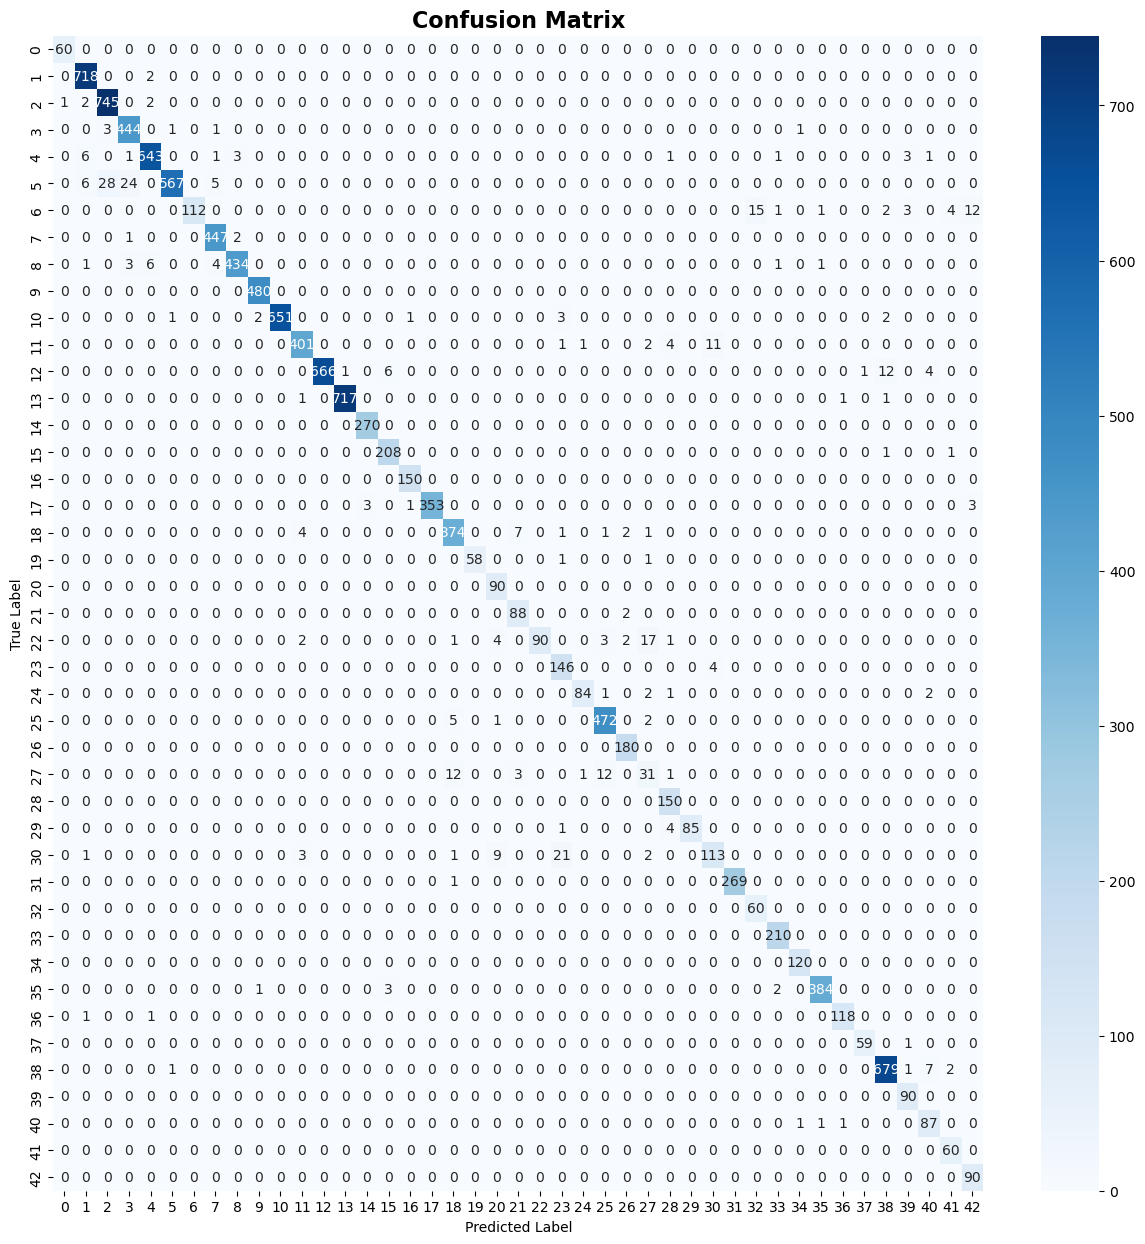

In [20]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (15, 15))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 16, fontweight = 'bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()